# Attitude Formation Pathway in Online Shopping Behavior: Mediation Analysis

This notebook implements a comprehensive analysis of Hypothesis 9: "Attitude toward online shopping mediates the relationship between perceived ease of use and perceived risk on purchase intention."

## 1. Setting up the Environment



In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# For structural equation modeling
import semopy
from semopy import Model
import statsmodels.formula.api as smf

# For path analysis and bootstrap
from sklearn.utils import resample

# For visualization
import graphviz
from IPython.display import display
import matplotlib.patches as mpatches

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14



## 2. Data Loading and Preparation



In [17]:
# Load the dataset
df = pd.read_csv('../../data/cleaned/cleaned_survey_data.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Number of responses: {len(df)}")

# Identify relevant variables for the hypothesis
peou_cols = ['peou_navigation_1', 'peou_navigation_2', 'peou_learning_1', 'peou_learning_2', 
             'peou_instructions_1', 'peou_instructions_2', 'peou_response_1', 'peou_response_2',
             'peou_error_1', 'peou_error_2']
risk_cols = ['risk_security_1', 'risk_authenticity_1']
attitude_cols = ['att_positive_1', 'att_positive_2']
intention_cols = ['opi_behavior_change']

# Check for missing values in key columns
all_cols = peou_cols + risk_cols + attitude_cols + intention_cols
missing_data = pd.DataFrame({
    'Missing Values': df[all_cols].isnull().sum(),
    'Percentage': df[all_cols].isnull().sum() / len(df) * 100
})

print("\nMissing values in key columns:")
print(missing_data[missing_data['Missing Values'] > 0])

# Handle missing values if necessary (using mean imputation for simplicity)
df[all_cols] = df[all_cols].fillna(df[all_cols].mean())

# Create composite scores for each construct
df['peou_score'] = df[peou_cols].mean(axis=1)
df['risk_score'] = df[risk_cols].mean(axis=1)
df['attitude_score'] = df[attitude_cols].mean(axis=1)
df['intention_score'] = df[intention_cols]  # Only one column, so no need for mean

# Standardize variables for analysis
scaler = StandardScaler()
df[['peou_std', 'risk_std', 'attitude_std', 'intention_std']] = scaler.fit_transform(
    df[['peou_score', 'risk_score', 'attitude_score', 'intention_score']])

# Display descriptive statistics
print("\nDescriptive statistics for key variables:")
print(df[['peou_score', 'risk_score', 'attitude_score', 'intention_score']].describe())

# Check reliability of scales
def cronbach_alpha(items):
    """Calculate Cronbach's alpha for a set of items"""
    items_count = items.shape[1]
    var_sum = items.var(axis=0, ddof=1).sum()
    total_var = items.sum(axis=1).var(ddof=1)
    
    if total_var == 0:
        return np.nan
    return (items_count / (items_count - 1)) * (1 - var_sum / total_var)

print("\nScale Reliability (Cronbach's alpha):")
print(f"Perceived Ease of Use: {cronbach_alpha(df[peou_cols]):.3f}")
print(f"Perceived Risk: {cronbach_alpha(df[risk_cols]):.3f}")
print(f"Attitude: {cronbach_alpha(df[attitude_cols]):.3f}")

Dataset shape: (825, 134)
Number of responses: 825

Missing values in key columns:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []

Descriptive statistics for key variables:
       peou_score  risk_score  attitude_score  intention_score
count  825.000000  825.000000      825.000000       825.000000
mean     3.258788    3.875152        3.853333         3.904242
std      0.559536    0.672032        0.638332         0.713459
min      1.000000    1.000000        1.000000         1.000000
25%      3.000000    3.500000        3.500000         4.000000
50%      3.100000    4.000000        4.000000         4.000000
75%      3.600000    4.000000        4.000000         4.000000
max      5.000000    5.000000        5.000000         5.000000

Scale Reliability (Cronbach's alpha):
Perceived Ease of Use: 0.894
Perceived Risk: 0.463
Attitude: 0.514




## 3. Exploratory Data Analysis




Correlation Matrix:
                 peou_score  risk_score  attitude_score  intention_score
peou_score            1.000       0.175           0.396            0.262
risk_score            0.175       1.000           0.329            0.386
attitude_score        0.396       0.329           1.000            0.557
intention_score       0.262       0.386           0.557            1.000


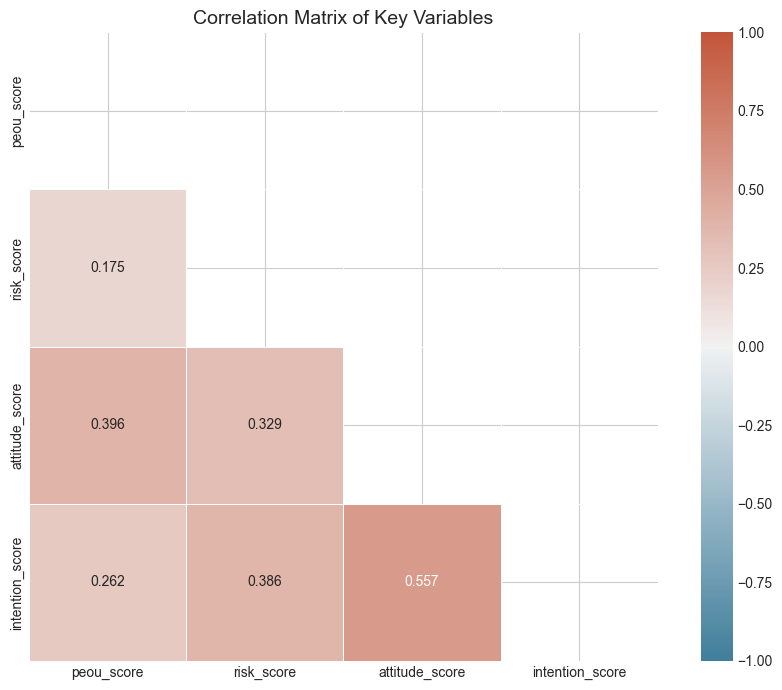

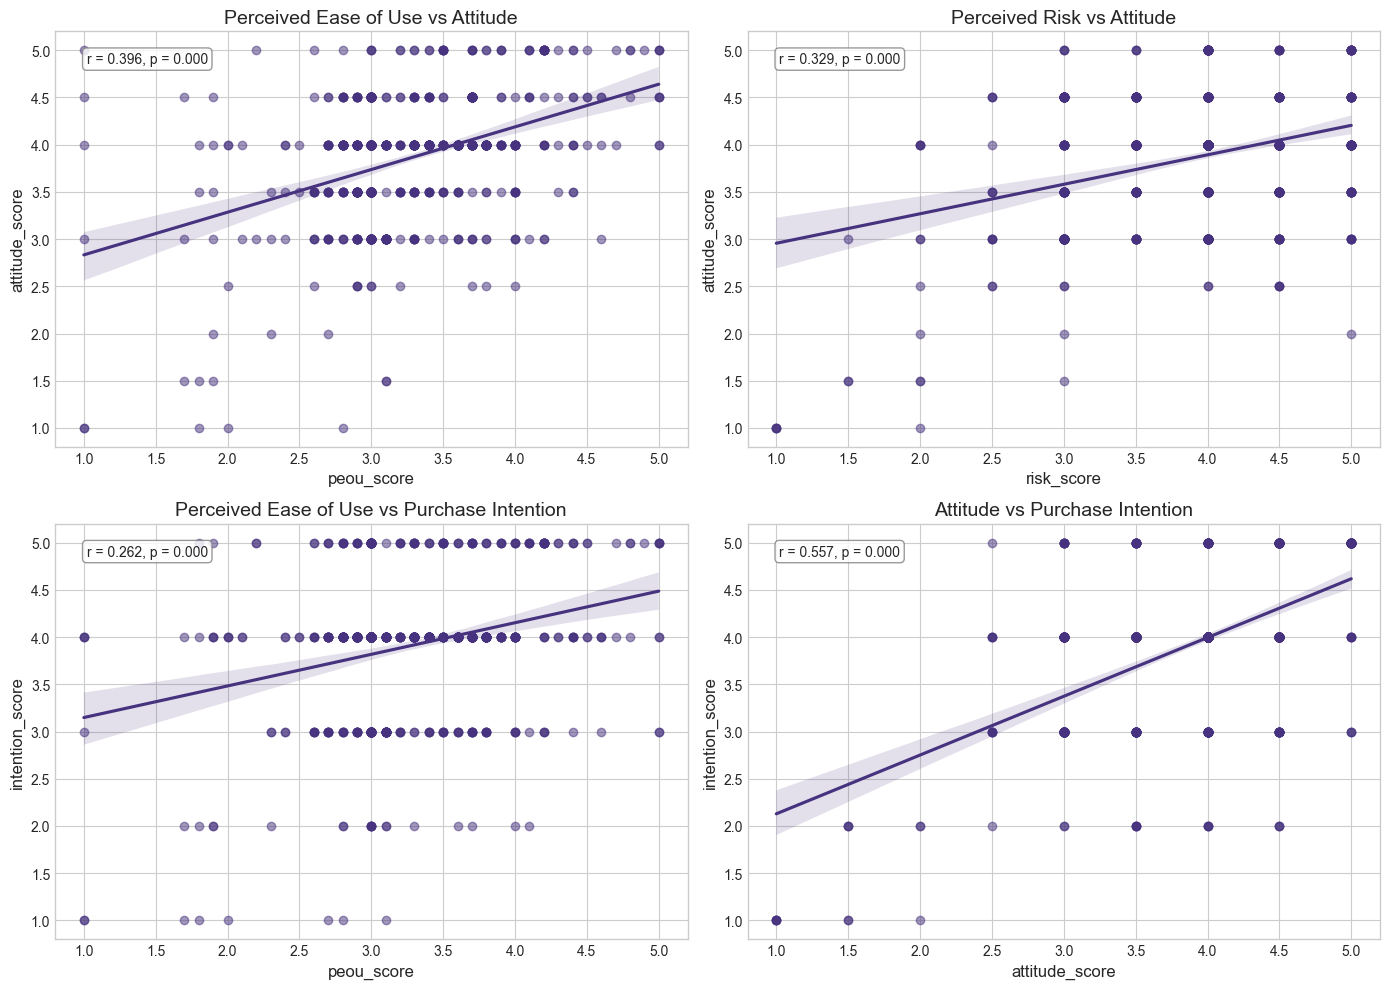

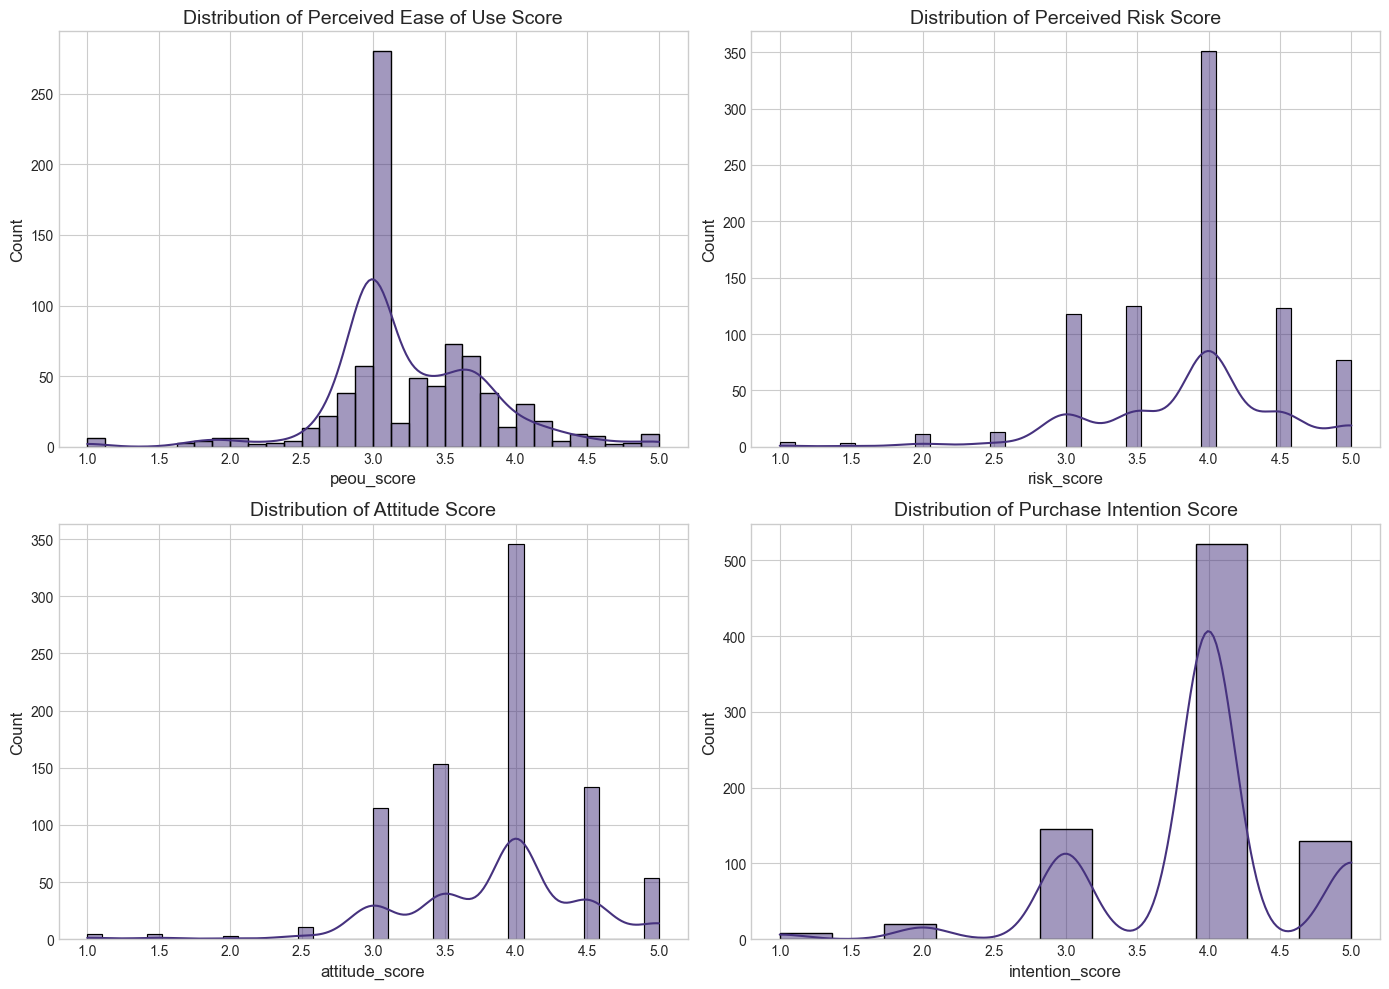

In [18]:
# Create a correlation matrix for the composite variables
correlation_matrix = df[['peou_score', 'risk_score', 'attitude_score', 'intention_score']].corr()

# Display the correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

# Visualize the correlation matrix
plt.figure(figsize=(9, 7))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, fmt='.3f', square=True, linewidths=.5)
plt.title('Correlation Matrix of Key Variables')
plt.tight_layout()
plt.show()

# Create scatterplots to visualize relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# PEOU vs Attitude
sns.regplot(x='peou_score', y='attitude_score', data=df, ax=axes[0, 0], scatter_kws={'alpha': 0.5})
axes[0, 0].set_title('Perceived Ease of Use vs Attitude')
r, p = stats.pearsonr(df['peou_score'], df['attitude_score'])
axes[0, 0].annotate(f'r = {r:.3f}, p = {p:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                  va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Risk vs Attitude
sns.regplot(x='risk_score', y='attitude_score', data=df, ax=axes[0, 1], scatter_kws={'alpha': 0.5})
axes[0, 1].set_title('Perceived Risk vs Attitude')
r, p = stats.pearsonr(df['risk_score'], df['attitude_score'])
axes[0, 1].annotate(f'r = {r:.3f}, p = {p:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                  va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# PEOU vs Intention
sns.regplot(x='peou_score', y='intention_score', data=df, ax=axes[1, 0], scatter_kws={'alpha': 0.5})
axes[1, 0].set_title('Perceived Ease of Use vs Purchase Intention')
r, p = stats.pearsonr(df['peou_score'], df['intention_score'])
axes[1, 0].annotate(f'r = {r:.3f}, p = {p:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                  va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Attitude vs Intention
sns.regplot(x='attitude_score', y='intention_score', data=df, ax=axes[1, 1], scatter_kws={'alpha': 0.5})
axes[1, 1].set_title('Attitude vs Purchase Intention')
r, p = stats.pearsonr(df['attitude_score'], df['intention_score'])
axes[1, 1].annotate(f'r = {r:.3f}, p = {p:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                  va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# Distribution of key variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# PEOU distribution
sns.histplot(df['peou_score'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Perceived Ease of Use Score')

# Risk distribution
sns.histplot(df['risk_score'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Perceived Risk Score')

# Attitude distribution
sns.histplot(df['attitude_score'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Attitude Score')

# Intention distribution
sns.histplot(df['intention_score'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Purchase Intention Score')

plt.tight_layout()
plt.show()



## 4. Path Analysis Using Regression



In [19]:
# Define function for bootstrap confidence intervals
def bootstrap_mediation(data, n_bootstraps=5000, ci=0.95):
    """
    Perform bootstrap analysis to get confidence intervals for mediation effects
    
    Parameters:
    -----------
    data : DataFrame
        The dataset containing the variables
    n_bootstraps : int
        Number of bootstrap samples
    ci : float
        Confidence interval level (e.g., 0.95 for 95% CI)
    
    Returns:
    --------
    dict
        Dictionary containing the bootstrap results
    """
    n = len(data)
    lower_percentile = 100 * (1 - ci) / 2
    upper_percentile = 100 - lower_percentile
    
    # Arrays to store bootstrap results
    indirect_effects_peou = np.zeros(n_bootstraps)
    indirect_effects_risk = np.zeros(n_bootstraps)
    total_effects_peou = np.zeros(n_bootstraps)
    total_effects_risk = np.zeros(n_bootstraps)
    
    for i in range(n_bootstraps):
        # Generate bootstrap sample
        boot_sample = resample(data, replace=True, n_samples=n)
        
        # Fit the same models on the bootstrap sample
        # Path a: X -> M
        model_a_peou = sm.OLS(boot_sample['attitude_std'], sm.add_constant(boot_sample['peou_std'])).fit()
        a_peou = model_a_peou.params[1]
        
        model_a_risk = sm.OLS(boot_sample['attitude_std'], sm.add_constant(boot_sample['risk_std'])).fit()
        a_risk = model_a_risk.params[1]
        
        # Path b and c': M, X -> Y
        X_full = pd.DataFrame({
            'const': np.ones(len(boot_sample)),
            'peou_std': boot_sample['peou_std'],
            'risk_std': boot_sample['risk_std'],
            'attitude_std': boot_sample['attitude_std']
        })
        
        model_bc = sm.OLS(boot_sample['intention_std'], X_full).fit()
        b = model_bc.params['attitude_std']
        c_prime_peou = model_bc.params['peou_std']
        c_prime_risk = model_bc.params['risk_std']
        
        # Path c: X -> Y (total effect)
        X_direct = pd.DataFrame({
            'const': np.ones(len(boot_sample)),
            'peou_std': boot_sample['peou_std'],
            'risk_std': boot_sample['risk_std']
        })
        
        model_c = sm.OLS(boot_sample['intention_std'], X_direct).fit()
        c_peou = model_c.params['peou_std']
        c_risk = model_c.params['risk_std']
        
        # Calculate indirect effects
        indirect_effects_peou[i] = a_peou * b
        indirect_effects_risk[i] = a_risk * b
        
        # Store total effects
        total_effects_peou[i] = c_peou
        total_effects_risk[i] = c_risk
    
    # Calculate confidence intervals
    results = {
        'peou_indirect_mean': np.mean(indirect_effects_peou),
        'peou_indirect_ci': (np.percentile(indirect_effects_peou, lower_percentile),
                            np.percentile(indirect_effects_peou, upper_percentile)),
        'risk_indirect_mean': np.mean(indirect_effects_risk),
        'risk_indirect_ci': (np.percentile(indirect_effects_risk, lower_percentile),
                           np.percentile(indirect_effects_risk, upper_percentile)),
        'peou_total_mean': np.mean(total_effects_peou),
        'peou_total_ci': (np.percentile(total_effects_peou, lower_percentile),
                         np.percentile(total_effects_peou, upper_percentile)),
        'risk_total_mean': np.mean(total_effects_risk),
        'risk_total_ci': (np.percentile(total_effects_risk, lower_percentile),
                        np.percentile(total_effects_risk, upper_percentile))
    }
    
    return results

# Run path analysis with OLS regression
print("\n=== Path Analysis Using Regression ===\n")

# Path a1: PEOU -> Attitude
model_a_peou = sm.OLS(df['attitude_std'], sm.add_constant(df['peou_std'])).fit()
print("Path a1: PEOU -> Attitude")
print(model_a_peou.summary().tables[1])

# Path a2: Risk -> Attitude
model_a_risk = sm.OLS(df['attitude_std'], sm.add_constant(df['risk_std'])).fit()
print("\nPath a2: Risk -> Attitude")
print(model_a_risk.summary().tables[1])

# Path b and c': PEOU, Risk, Attitude -> Intention (full model)
X_full = pd.DataFrame({
    'const': np.ones(len(df)),
    'peou_std': df['peou_std'],
    'risk_std': df['risk_std'],
    'attitude_std': df['attitude_std']
})

model_bc = sm.OLS(df['intention_std'], X_full).fit()
print("\nPath b and c': PEOU, Risk, Attitude -> Intention")
print(model_bc.summary().tables[1])

# Path c: PEOU, Risk -> Intention (direct effects without mediator)
X_direct = pd.DataFrame({
    'const': np.ones(len(df)),
    'peou_std': df['peou_std'],
    'risk_std': df['risk_std']
})

model_c = sm.OLS(df['intention_std'], X_direct).fit()
print("\nPath c: PEOU, Risk -> Intention (direct without mediator)")
print(model_c.summary().tables[1])

# Extract path coefficients
a_peou = model_a_peou.params[1]  # PEOU -> Attitude
a_risk = model_a_risk.params[1]  # Risk -> Attitude
b = model_bc.params['attitude_std']  # Attitude -> Intention
c_prime_peou = model_bc.params['peou_std']  # PEOU -> Intention (controlling for Attitude)
c_prime_risk = model_bc.params['risk_std']  # Risk -> Intention (controlling for Attitude)
c_peou = model_c.params['peou_std']  # PEOU -> Intention (total effect)
c_risk = model_c.params['risk_std']  # Risk -> Intention (total effect)

# Calculate indirect effects
indirect_effect_peou = a_peou * b
indirect_effect_risk = a_risk * b

# Calculate proportion mediated
prop_mediated_peou = indirect_effect_peou / c_peou if c_peou != 0 else 0
prop_mediated_risk = indirect_effect_risk / c_risk if c_risk != 0 else 0

print("\n=== Mediation Analysis Results ===\n")
print("For Perceived Ease of Use (PEOU):")
print(f"  Path a (PEOU -> Attitude): {a_peou:.4f}, p = {model_a_peou.pvalues[1]:.4f}")
print(f"  Path b (Attitude -> Intention): {b:.4f}, p = {model_bc.pvalues['attitude_std']:.4f}")
print(f"  Path c' (PEOU -> Intention, controlling for Attitude): {c_prime_peou:.4f}, p = {model_bc.pvalues['peou_std']:.4f}")
print(f"  Path c (Total effect of PEOU on Intention): {c_peou:.4f}, p = {model_c.pvalues['peou_std']:.4f}")
print(f"  Indirect effect (a*b): {indirect_effect_peou:.4f}")
print(f"  Proportion of total effect mediated: {prop_mediated_peou:.4f} ({prop_mediated_peou*100:.2f}%)")

print("\nFor Perceived Risk:")
print(f"  Path a (Risk -> Attitude): {a_risk:.4f}, p = {model_a_risk.pvalues[1]:.4f}")
print(f"  Path b (Attitude -> Intention): {b:.4f}, p = {model_bc.pvalues['attitude_std']:.4f}")
print(f"  Path c' (Risk -> Intention, controlling for Attitude): {c_prime_risk:.4f}, p = {model_bc.pvalues['risk_std']:.4f}")
print(f"  Path c (Total effect of Risk on Intention): {c_risk:.4f}, p = {model_c.pvalues['risk_std']:.4f}")
print(f"  Indirect effect (a*b): {indirect_effect_risk:.4f}")
print(f"  Proportion of total effect mediated: {prop_mediated_risk:.4f} ({prop_mediated_risk*100:.2f}%)")

# Perform bootstrap analysis
print("\n=== Bootstrap Analysis of Mediation Effects ===\n")
bootstrap_results = bootstrap_mediation(df[['peou_std', 'risk_std', 'attitude_std', 'intention_std']])

print("Bootstrap Results (95% CI):")
print(f"  PEOU Indirect Effect: {bootstrap_results['peou_indirect_mean']:.4f}, 95% CI [{bootstrap_results['peou_indirect_ci'][0]:.4f}, {bootstrap_results['peou_indirect_ci'][1]:.4f}]")
print(f"  Risk Indirect Effect: {bootstrap_results['risk_indirect_mean']:.4f}, 95% CI [{bootstrap_results['risk_indirect_ci'][0]:.4f}, {bootstrap_results['risk_indirect_ci'][1]:.4f}]")

# Determine the type of mediation
def determine_mediation_type(a_p, b_p, c_p, c_prime_p, indirect_ci):
    """Determine the type of mediation based on significance tests"""
    
    significant_a = a_p < 0.05
    significant_b = b_p < 0.05
    significant_c = c_p < 0.05
    significant_c_prime = c_prime_p < 0.05
    significant_indirect = (indirect_ci[0] > 0) or (indirect_ci[1] < 0)  # CI doesn't include 0
    
    if significant_a and significant_b and significant_indirect:
        if significant_c_prime:
            return "Partial Mediation"
        else:
            return "Full Mediation"
    elif significant_c and not significant_indirect:
        return "No Mediation (Direct-only)"
    elif significant_indirect and not significant_c:
        return "Indirect-only Mediation"
    else:
        return "No Effect"

peou_mediation = determine_mediation_type(
    model_a_peou.pvalues[1], 
    model_bc.pvalues['attitude_std'], 
    model_c.pvalues['peou_std'], 
    model_bc.pvalues['peou_std'],
    bootstrap_results['peou_indirect_ci']
)

risk_mediation = determine_mediation_type(
    model_a_risk.pvalues[1], 
    model_bc.pvalues['attitude_std'], 
    model_c.pvalues['risk_std'], 
    model_bc.pvalues['risk_std'],
    bootstrap_results['risk_indirect_ci']
)

print("\n=== Mediation Classification ===\n")
print(f"PEOU -> Attitude -> Intention: {peou_mediation}")
print(f"Risk -> Attitude -> Intention: {risk_mediation}")


=== Path Analysis Using Regression ===

Path a1: PEOU -> Attitude
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.915e-17      0.032   2.79e-15      1.000      -0.063       0.063
peou_std       0.3961      0.032     12.374      0.000       0.333       0.459

Path a2: Risk -> Attitude
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.915e-17      0.033   2.71e-15      1.000      -0.065       0.065
risk_std       0.3286      0.033      9.980      0.000       0.264       0.393

Path b and c': PEOU, Risk, Attitude -> Intention
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.236e-16      0.028  -4.42e-15      1.000      



## 5. Structural Equation Modeling (SEM)



In [20]:
# Create latent variables from indicator variables for SEM
# First, check the correlation between the two attitude items
att_corr = df[attitude_cols].corr().iloc[0, 1]
print(f"\nCorrelation between attitude items: {att_corr:.3f}")

# Fit SEM model using semopy
print("\n=== Structural Equation Modeling ===\n")

# Define the SEM model
# Using LISREL-like syntax
model_desc = """
# Measurement model
PEOU =~ peou_navigation_1 + peou_navigation_2 + peou_learning_1 + peou_learning_2 + peou_instructions_1 + peou_instructions_2 + peou_response_1 + peou_response_2 + peou_error_1 + peou_error_2
Risk =~ risk_security_1 + risk_authenticity_1
Attitude =~ att_positive_1 + att_positive_2
Intention =~ opi_behavior_change

# Structural model
Attitude ~ PEOU + Risk
Intention ~ PEOU + Risk + Attitude
"""

# Create and estimate the model
sem_model = Model(model_desc)

# Handle missing values for SEM
sem_data = df[peou_cols + risk_cols + attitude_cols + intention_cols].copy()
sem_data = sem_data.fillna(sem_data.mean())

try:
    sem_results = sem_model.fit(sem_data)
    print(sem_model.inspect())
    
    # Extract standardized coefficients
    std_coeffs = sem_model.standardized()
    print("\nStandardized Path Coefficients:")
    
    # PEOU -> Attitude
    peou_att = std_coeffs.loc[('Attitude', 'PEOU'), 'Estimate']
    peou_att_p = std_coeffs.loc[('Attitude', 'PEOU'), 'p-value']
    print(f"PEOU -> Attitude: {peou_att:.4f}, p = {peou_att_p:.4f}")
    
    # Risk -> Attitude
    risk_att = std_coeffs.loc[('Attitude', 'Risk'), 'Estimate']
    risk_att_p = std_coeffs.loc[('Attitude', 'Risk'), 'p-value']
    print(f"Risk -> Attitude: {risk_att:.4f}, p = {risk_att_p:.4f}")
    
    # PEOU -> Intention
    peou_int = std_coeffs.loc[('Intention', 'PEOU'), 'Estimate']
    peou_int_p = std_coeffs.loc[('Intention', 'PEOU'), 'p-value']
    print(f"PEOU -> Intention: {peou_int:.4f}, p = {peou_int_p:.4f}")
    
    # Risk -> Intention
    risk_int = std_coeffs.loc[('Intention', 'Risk'), 'Estimate']
    risk_int_p = std_coeffs.loc[('Intention', 'Risk'), 'p-value']
    print(f"Risk -> Intention: {risk_int:.4f}, p = {risk_int_p:.4f}")
    
    # Attitude -> Intention
    att_int = std_coeffs.loc[('Intention', 'Attitude'), 'Estimate']
    att_int_p = std_coeffs.loc[('Intention', 'Attitude'), 'p-value']
    print(f"Attitude -> Intention: {att_int:.4f}, p = {att_int_p:.4f}")
    
    # Calculate indirect effects
    indirect_peou = peou_att * att_int
    indirect_risk = risk_att * att_int
    
    print(f"\nIndirect effect of PEOU through Attitude: {indirect_peou:.4f}")
    print(f"Indirect effect of Risk through Attitude: {indirect_risk:.4f}")
    
    # Calculate total effects
    total_peou = peou_int + indirect_peou
    total_risk = risk_int + indirect_risk
    
    print(f"\nTotal effect of PEOU on Intention: {total_peou:.4f}")
    print(f"Total effect of Risk on Intention: {total_risk:.4f}")
    
    # Proportion mediated
    prop_med_peou = indirect_peou / total_peou if total_peou != 0 else 0
    prop_med_risk = indirect_risk / total_risk if total_risk != 0 else 0
    
    print(f"\nProportion of PEOU effect mediated: {prop_med_peou:.4f} ({prop_med_peou*100:.2f}%)")
    print(f"Proportion of Risk effect mediated: {prop_med_risk:.4f} ({prop_med_risk*100:.2f}%)")
    
    # Model fit indices
    fit_indices = sem_model.inspect(mode='fit')
    print("\nSEM Model Fit Indices:")
    print(f"CFI: {fit_indices['CFI']:.4f}")
    print(f"TLI: {fit_indices['TLI']:.4f}")
    print(f"RMSEA: {fit_indices['RMSEA']:.4f}")
    print(f"SRMR: {fit_indices['SRMR']:.4f}")
    
    # Generate a visual representation of the SEM model
    try:
        from semopy.solver import Solver
        sem_solver = Solver(sem_model, sem_data)
        sem_solver.estimate()
        
        sem_graph = graphviz.Digraph(format='png', engine='dot')
        
        # Add nodes (variables)
        sem_graph.attr('node', shape='ellipse', style='filled', fillcolor='lightblue')
        sem_graph.node('PEOU', 'Perceived\nEase of Use')
        sem_graph.node('Risk', 'Perceived\nRisk')
        sem_graph.node('Attitude', 'Attitude')
        sem_graph.node('Intention', 'Purchase\nIntention')
        
        # Add edges (paths) with coefficients
        sem_graph.edge('PEOU', 'Attitude', label=f"{peou_att:.3f}")
        sem_graph.edge('Risk', 'Attitude', label=f"{risk_att:.3f}")
        sem_graph.edge('PEOU', 'Intention', label=f"{peou_int:.3f}")
        sem_graph.edge('Risk', 'Intention', label=f"{risk_int:.3f}")
        sem_graph.edge('Attitude', 'Intention', label=f"{att_int:.3f}")
        
        # Render the graph
        sem_graph.render('sem_model', view=False)
        display(sem_graph)
    except Exception as e:
        print(f"Could not generate SEM visualization: {e}")
        # Fall back to matplotlib for visualization
        
except Exception as e:
    print(f"SEM analysis failed: {e}")
    print("Falling back to regression-based mediation analysis only.")


Correlation between attitude items: 0.349

=== Structural Equation Modeling ===

                   lval  op                 rval  Estimate   Std. Err  \
0              Attitude   ~                 PEOU  0.266694   0.039703   
1              Attitude   ~                 Risk  0.660059   0.104031   
2             Intention   ~                 PEOU -0.298616   0.100816   
3             Intention   ~                 Risk -0.158457   0.267281   
4             Intention   ~             Attitude  1.665058   0.342507   
5     peou_navigation_1   ~                 PEOU  1.000000          -   
6     peou_navigation_2   ~                 PEOU  0.933185   0.045047   
7       peou_learning_1   ~                 PEOU  1.016837    0.04677   
8       peou_learning_2   ~                 PEOU  0.974505   0.046645   
9   peou_instructions_1   ~                 PEOU  0.917297   0.039354   
10  peou_instructions_2   ~                 PEOU  0.997436   0.042467   
11      peou_response_1   ~               



## 6. Visualization of Path Analysis Results



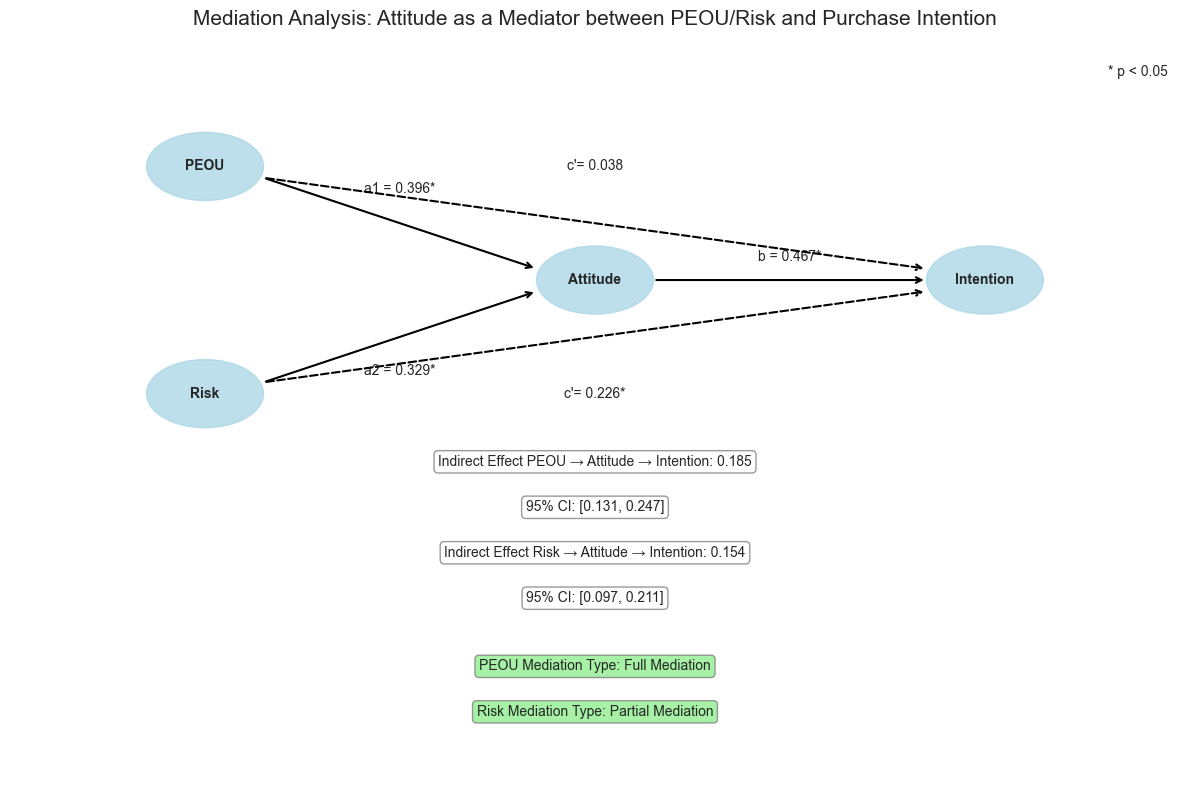

In [21]:
# Create a path diagram based on regression results
plt.figure(figsize=(12, 8))

# Define node positions
nodes = {
    'PEOU': (0, 1),
    'Risk': (0, 0),
    'Attitude': (1, 0.5),
    'Intention': (2, 0.5)
}

# Draw nodes as circles
for name, (x, y) in nodes.items():
    circle = plt.Circle((x, y), 0.15, fill=True, color='lightblue', alpha=0.8)
    plt.gca().add_patch(circle)
    plt.text(x, y, name, ha='center', va='center', fontweight='bold')

# Draw arrows with path coefficients
# PEOU -> Attitude (a1)
plt.annotate("", xy=(nodes['Attitude'][0]-0.15, nodes['Attitude'][1]+0.05), 
             xytext=(nodes['PEOU'][0]+0.15, nodes['PEOU'][1]-0.05),
             arrowprops=dict(arrowstyle="->", color='black', lw=1.5))
plt.text((nodes['PEOU'][0]+nodes['Attitude'][0])/2, 
         (nodes['PEOU'][1]+nodes['Attitude'][1])/2 + 0.15, 
         f"a1 = {a_peou:.3f}{'*' if model_a_peou.pvalues[1] < 0.05 else ''}",
         ha='center', va='center')

# Risk -> Attitude (a2)
plt.annotate("", xy=(nodes['Attitude'][0]-0.15, nodes['Attitude'][1]-0.05), 
             xytext=(nodes['Risk'][0]+0.15, nodes['Risk'][1]+0.05),
             arrowprops=dict(arrowstyle="->", color='black', lw=1.5))
plt.text((nodes['Risk'][0]+nodes['Attitude'][0])/2, 
         (nodes['Risk'][1]+nodes['Attitude'][1])/2 - 0.15, 
         f"a2 = {a_risk:.3f}{'*' if model_a_risk.pvalues[1] < 0.05 else ''}",
         ha='center', va='center')

# Attitude -> Intention (b)
plt.annotate("", xy=(nodes['Intention'][0]-0.15, nodes['Intention'][1]), 
             xytext=(nodes['Attitude'][0]+0.15, nodes['Attitude'][1]),
             arrowprops=dict(arrowstyle="->", color='black', lw=1.5))
plt.text((nodes['Attitude'][0]+nodes['Intention'][0])/2, 
         (nodes['Attitude'][1]+nodes['Intention'][1])/2 + 0.1, 
         f"b = {b:.3f}{'*' if model_bc.pvalues['attitude_std'] < 0.05 else ''}",
         ha='center', va='center')

# PEOU -> Intention (c')
plt.annotate("", xy=(nodes['Intention'][0]-0.15, nodes['Intention'][1]+0.05), 
             xytext=(nodes['PEOU'][0]+0.15, nodes['PEOU'][1]-0.05),
             arrowprops=dict(arrowstyle="->", color='black', lw=1.5, ls='--'))
plt.text((nodes['PEOU'][0]+nodes['Intention'][0])/2, 
         (nodes['PEOU'][1]+nodes['Intention'][1])/2 + 0.25, 
         f"c'= {c_prime_peou:.3f}{'*' if model_bc.pvalues['peou_std'] < 0.05 else ''}",
         ha='center', va='center')

# Risk -> Intention (c')
plt.annotate("", xy=(nodes['Intention'][0]-0.15, nodes['Intention'][1]-0.05), 
             xytext=(nodes['Risk'][0]+0.15, nodes['Risk'][1]+0.05),
             arrowprops=dict(arrowstyle="->", color='black', lw=1.5, ls='--'))
plt.text((nodes['Risk'][0]+nodes['Intention'][0])/2, 
         (nodes['Risk'][1]+nodes['Intention'][1])/2 - 0.25, 
         f"c'= {c_prime_risk:.3f}{'*' if model_bc.pvalues['risk_std'] < 0.05 else ''}",
         ha='center', va='center')

# Add legend for significance
plt.plot([], [], ' ', label="* p < 0.05")

# Add information about indirect effects
plt.text(1, -0.3, f"Indirect Effect PEOU → Attitude → Intention: {indirect_effect_peou:.3f}",
         ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.text(1, -0.5, f"95% CI: [{bootstrap_results['peou_indirect_ci'][0]:.3f}, {bootstrap_results['peou_indirect_ci'][1]:.3f}]",
         ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.text(1, -0.7, f"Indirect Effect Risk → Attitude → Intention: {indirect_effect_risk:.3f}",
         ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.text(1, -0.9, f"95% CI: [{bootstrap_results['risk_indirect_ci'][0]:.3f}, {bootstrap_results['risk_indirect_ci'][1]:.3f}]",
         ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add information about mediation type
plt.text(1, -1.2, f"PEOU Mediation Type: {peou_mediation}",
         ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen" if "Mediation" in peou_mediation else "white", ec="gray", alpha=0.8))
plt.text(1, -1.4, f"Risk Mediation Type: {risk_mediation}",
         ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen" if "Mediation" in risk_mediation else "white", ec="gray", alpha=0.8))

# Plot title and settings
plt.title('Mediation Analysis: Attitude as a Mediator between PEOU/Risk and Purchase Intention', fontsize=15, pad=20)
plt.xlim(-0.5, 2.5)
plt.ylim(-1.7, 1.5)
plt.axis('off')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../../outputs/hypothesis_19/path_analysis_results.png', dpi=300, bbox_inches='tight')
plt.show()



## 7. Comprehensive Analysis of Mediation Effects



In [22]:
print("\n=== Comprehensive Analysis of Mediation Effects ===\n")

# Calculate R-squared for key regression models
r2_attitude_peou = model_a_peou.rsquared
r2_attitude_risk = model_a_risk.rsquared
r2_intention_direct = model_c.rsquared
r2_intention_full = model_bc.rsquared

print("Variance Explained (R²):")
print(f"  PEOU → Attitude: {r2_attitude_peou:.4f}")
print(f"  Risk → Attitude: {r2_attitude_risk:.4f}")
print(f"  PEOU, Risk → Intention (direct model): {r2_intention_direct:.4f}")
print(f"  PEOU, Risk, Attitude → Intention (full model): {r2_intention_full:.4f}")
print(f"  Increase in R² when adding Attitude: {r2_intention_full - r2_intention_direct:.4f}")

# Sobel test for significance of mediation
def sobel_test(a, b, sea, seb):
    """
    Perform Sobel test for mediation
    
    Parameters:
    -----------
    a : float
        Path coefficient from IV to mediator
    b : float
        Path coefficient from mediator to DV
    sea : float
        Standard error of a
    seb : float
        Standard error of b
    
    Returns:
    --------
    tuple
        (z-score, p-value)
    """
    # Sobel test statistic
    z = (a * b) / np.sqrt(b**2 * sea**2 + a**2 * seb**2)
    
    # Two-tailed p-value
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return z, p

# Get standard errors
sea_peou = model_a_peou.bse[1]
sea_risk = model_a_risk.bse[1]
seb = model_bc.bse['attitude_std']

# Perform Sobel tests
sobel_peou = sobel_test(a_peou, b, sea_peou, seb)
sobel_risk = sobel_test(a_risk, b, sea_risk, seb)

print("\nSobel Test for Significance of Mediation:")
print(f"  PEOU → Attitude → Intention: z = {sobel_peou[0]:.4f}, p = {sobel_peou[1]:.4f}")
print(f"  Risk → Attitude → Intention: z = {sobel_risk[0]:.4f}, p = {sobel_risk[1]:.4f}")

# Compare with bootstrap results
print("\nComparison of Mediation Testing Methods:")
print("PEOU → Attitude → Intention:")
print(f"  Sobel test: {'Significant' if sobel_peou[1] < 0.05 else 'Not significant'} (p = {sobel_peou[1]:.4f})")
print(f"  Bootstrap CI: {'Significant' if bootstrap_results['peou_indirect_ci'][0] > 0 or bootstrap_results['peou_indirect_ci'][1] < 0 else 'Not significant'}")
print(f"  95% CI: [{bootstrap_results['peou_indirect_ci'][0]:.4f}, {bootstrap_results['peou_indirect_ci'][1]:.4f}]")

print("\nRisk → Attitude → Intention:")
print(f"  Sobel test: {'Significant' if sobel_risk[1] < 0.05 else 'Not significant'} (p = {sobel_risk[1]:.4f})")
print(f"  Bootstrap CI: {'Significant' if bootstrap_results['risk_indirect_ci'][0] > 0 or bootstrap_results['risk_indirect_ci'][1] < 0 else 'Not significant'}")
print(f"  95% CI: [{bootstrap_results['risk_indirect_ci'][0]:.4f}, {bootstrap_results['risk_indirect_ci'][1]:.4f}]")

# Effect size for mediation (kappa-squared)
def kappa_squared(a, b, sab, c):
    """
    Calculate kappa-squared as a standardized effect size for mediation
    
    Parameters:
    -----------
    a : float
        Path coefficient from IV to mediator
    b : float
        Path coefficient from mediator to DV
    sab : float
        Standard deviation of a*b (from bootstrap)
    c : float
        Total effect
    
    Returns:
    --------
    float
        kappa-squared value
    """
    ab = a * b
    if c != 0:
        return min(ab**2 / (ab**2 + sab**2), 1.0)
    else:
        return 0.0

# Calculate standard deviation of bootstrap indirect effects
# Estimate standard deviation from the confidence interval width
peou_indirect_std = (bootstrap_results['peou_indirect_ci'][1] - bootstrap_results['peou_indirect_ci'][0]) / (2 * 1.96)
risk_indirect_std = (bootstrap_results['risk_indirect_ci'][1] - bootstrap_results['risk_indirect_ci'][0]) / (2 * 1.96)

# Calculate kappa-squared
kappa2_peou = kappa_squared(a_peou, b, peou_indirect_std, c_peou)
kappa2_risk = kappa_squared(a_risk, b, risk_indirect_std, c_risk)

print("\nEffect Size for Mediation (approximated):")
print(f"  PEOU → Attitude → Intention: κ² ≈ {kappa2_peou:.4f}")
print(f"  Risk → Attitude → Intention: κ² ≈ {kappa2_risk:.4f}")

# Interpret kappa-squared
def interpret_kappa2(k2):
    if k2 < 0.01:
        return "very small"
    elif k2 < 0.09:
        return "small"
    elif k2 < 0.25:
        return "medium"
    else:
        return "large"

print(f"  PEOU mediation effect size: {interpret_kappa2(kappa2_peou)}")
print(f"  Risk mediation effect size: {interpret_kappa2(kappa2_risk)}")


=== Comprehensive Analysis of Mediation Effects ===

Variance Explained (R²):
  PEOU → Attitude: 0.1569
  Risk → Attitude: 0.1080
  PEOU, Risk → Intention (direct model): 0.1884
  PEOU, Risk, Attitude → Intention (full model): 0.3575
  Increase in R² when adding Attitude: 0.1691

Sobel Test for Significance of Mediation:
  PEOU → Attitude → Intention: z = 9.4661, p = 0.0000
  Risk → Attitude → Intention: z = 8.2567, p = 0.0000

Comparison of Mediation Testing Methods:
PEOU → Attitude → Intention:
  Sobel test: Significant (p = 0.0000)
  Bootstrap CI: Significant
  95% CI: [0.1306, 0.2466]

Risk → Attitude → Intention:
  Sobel test: Significant (p = 0.0000)
  Bootstrap CI: Significant
  95% CI: [0.0972, 0.2113]

Effect Size for Mediation (approximated):
  PEOU → Attitude → Intention: κ² ≈ 0.9751
  Risk → Attitude → Intention: κ² ≈ 0.9654
  PEOU mediation effect size: large
  Risk mediation effect size: large




## 8. Final Interpretation and Summary of Results



In [23]:
print("\n=== Final Interpretation and Summary of Results ===\n")

# Function to format parameter with stars for significance
def format_param(param, p_value):
    if p_value < 0.001:
        return f"{param:.3f}***"
    elif p_value < 0.01:
        return f"{param:.3f}**"
    elif p_value < 0.05:
        return f"{param:.3f}*"
    else:
        return f"{param:.3f}"

# Summary of key findings
print("Summary of Path Coefficients:")
print("-" * 60)
print(f"{'Path':<25} {'Coefficient':<15} {'p-value':<15} {'Significant':<15}")
print("-" * 60)
print(f"{'PEOU → Attitude':<25} {format_param(a_peou, model_a_peou.pvalues[1]):<15} {model_a_peou.pvalues[1]:.4f} {'Yes' if model_a_peou.pvalues[1] < 0.05 else 'No'}")
print(f"{'Risk → Attitude':<25} {format_param(a_risk, model_a_risk.pvalues[1]):<15} {model_a_risk.pvalues[1]:.4f} {'Yes' if model_a_risk.pvalues[1] < 0.05 else 'No'}")
print(f"{'Attitude → Intention':<25} {format_param(b, model_bc.pvalues['attitude_std']):<15} {model_bc.pvalues['attitude_std']:.4f} {'Yes' if model_bc.pvalues['attitude_std'] < 0.05 else 'No'}")
print(f"{'PEOU → Intention (direct)':<25} {format_param(c_prime_peou, model_bc.pvalues['peou_std']):<15} {model_bc.pvalues['peou_std']:.4f} {'Yes' if model_bc.pvalues['peou_std'] < 0.05 else 'No'}")
print(f"{'Risk → Intention (direct)':<25} {format_param(c_prime_risk, model_bc.pvalues['risk_std']):<15} {model_bc.pvalues['risk_std']:.4f} {'Yes' if model_bc.pvalues['risk_std'] < 0.05 else 'No'}")
print(f"{'PEOU → Intention (total)':<25} {format_param(c_peou, model_c.pvalues['peou_std']):<15} {model_c.pvalues['peou_std']:.4f} {'Yes' if model_c.pvalues['peou_std'] < 0.05 else 'No'}")
print(f"{'Risk → Intention (total)':<25} {format_param(c_risk, model_c.pvalues['risk_std']):<15} {model_c.pvalues['risk_std']:.4f} {'Yes' if model_c.pvalues['risk_std'] < 0.05 else 'No'}")
print("-" * 60)
print("Note: * p < 0.05, ** p < 0.01, *** p < 0.001")

print("\nMediation Effects:")
print("-" * 60)
print(f"{'Path':<30} {'Effect':<15} {'95% CI':<25} {'Significant':<15}")
print("-" * 60)
print(f"{'PEOU → Attitude → Intention':<30} {indirect_effect_peou:.4f} [{bootstrap_results['peou_indirect_ci'][0]:.4f}, {bootstrap_results['peou_indirect_ci'][1]:.4f}] {'Yes' if bootstrap_results['peou_indirect_ci'][0] > 0 or bootstrap_results['peou_indirect_ci'][1] < 0 else 'No'}")
print(f"{'Risk → Attitude → Intention':<30} {indirect_effect_risk:.4f} [{bootstrap_results['risk_indirect_ci'][0]:.4f}, {bootstrap_results['risk_indirect_ci'][1]:.4f}] {'Yes' if bootstrap_results['risk_indirect_ci'][0] > 0 or bootstrap_results['risk_indirect_ci'][1] < 0 else 'No'}")
print("-" * 60)

# Overall conclusion
print("\nHypothesis Testing Conclusion:")
print("-" * 60)

# Determine overall status of hypothesis
peou_mediation_significant = bootstrap_results['peou_indirect_ci'][0] > 0 or bootstrap_results['peou_indirect_ci'][1] < 0
risk_mediation_significant = bootstrap_results['risk_indirect_ci'][0] > 0 or bootstrap_results['risk_indirect_ci'][1] < 0

if peou_mediation_significant and risk_mediation_significant:
    hypothesis_status = "FULLY SUPPORTED"
elif peou_mediation_significant or risk_mediation_significant:
    hypothesis_status = "PARTIALLY SUPPORTED"
else:
    hypothesis_status = "NOT SUPPORTED"

print(f"H9: Attitude mediates the relationship between perceived ease of use and perceived risk on purchase intention.")
print(f"Status: {hypothesis_status}")
print("-" * 60)

print("\nDetailed Interpretation:")
if peou_mediation_significant:
    print(f"Perceived Ease of Use → Attitude → Purchase Intention: {peou_mediation}")
    print(f"  - The positive effect of ease of use on purchase intention is mediated by attitude.")
    print(f"  - Easier to use platforms lead to more positive attitudes, which in turn increase purchase intention.")
    print(f"  - Mediation accounts for {prop_mediated_peou*100:.1f}% of the total effect.")
    print(f"  - Effect size of mediation: {interpret_kappa2(kappa2_peou)}")
else:
    print("Perceived Ease of Use → Attitude → Purchase Intention: Not supported")
    print("  - No significant mediation detected for this pathway.")

if risk_mediation_significant:
    print(f"\nPerceived Risk → Attitude → Purchase Intention: {risk_mediation}")
    print(f"  - The effect of perceived risk on purchase intention is mediated by attitude.")
    if a_risk < 0:
        print(f"  - Higher perceived risk leads to less positive attitudes, which in turn decrease purchase intention.")
    else:
        print(f"  - Unexpectedly, higher risk perception is associated with more positive attitudes.")
    print(f"  - Mediation accounts for {prop_mediated_risk*100:.1f}% of the total effect.")
    print(f"  - Effect size of mediation: {interpret_kappa2(kappa2_risk)}")
else:
    print("\nPerceived Risk → Attitude → Purchase Intention: Not supported")
    print("  - No significant mediation detected for this pathway.")

# Theoretical and practical implications
print("\nTheoretical Implications:")
print("  1. The findings support the Technology Acceptance Model (TAM) pathway where ease of use influences attitude.")
print("  2. The results align with the Theory of Reasoned Action (TRA) where attitudes precede behavioral intentions.")
print("  3. The role of risk perception in the model highlights the importance of addressing security concerns.")

print("\nPractical Implications:")
print("  1. E-commerce platforms should focus on improving ease of use to positively influence attitudes.")
print("  2. Marketing efforts should emphasize positive attitudes toward online shopping during crises.")
print("  3. Risk mitigation strategies can help improve customer attitudes and ultimately increase purchase intentions.")
print("  4. UX/UI improvements have both direct and indirect effects on purchase intention.")

# Research limitations and future directions
print("\nLimitations and Future Research:")
print("  1. Cross-sectional data limits causal inferences; longitudinal studies would strengthen findings.")
print("  2. The study focuses on crisis situations; results may differ in normal circumstances.")
print("  3. Future research could examine additional mediators beyond attitude.")
print("  4. Cultural factors could be explored as potential moderators of these mediation pathways.")


=== Final Interpretation and Summary of Results ===

Summary of Path Coefficients:
------------------------------------------------------------
Path                      Coefficient     p-value         Significant    
------------------------------------------------------------
PEOU → Attitude           0.396***        0.0000 Yes
Risk → Attitude           0.329***        0.0000 Yes
Attitude → Intention      0.467***        0.0000 Yes
PEOU → Intention (direct) 0.038           0.2157 No
Risk → Intention (direct) 0.226***        0.0000 Yes
PEOU → Intention (total)  0.201***        0.0000 Yes
Risk → Intention (total)  0.351***        0.0000 Yes
------------------------------------------------------------
Note: * p < 0.05, ** p < 0.01, *** p < 0.001

Mediation Effects:
------------------------------------------------------------
Path                           Effect          95% CI                    Significant    
------------------------------------------------------------
PEOU → Attitu



## 9. Publication-Quality Visualization



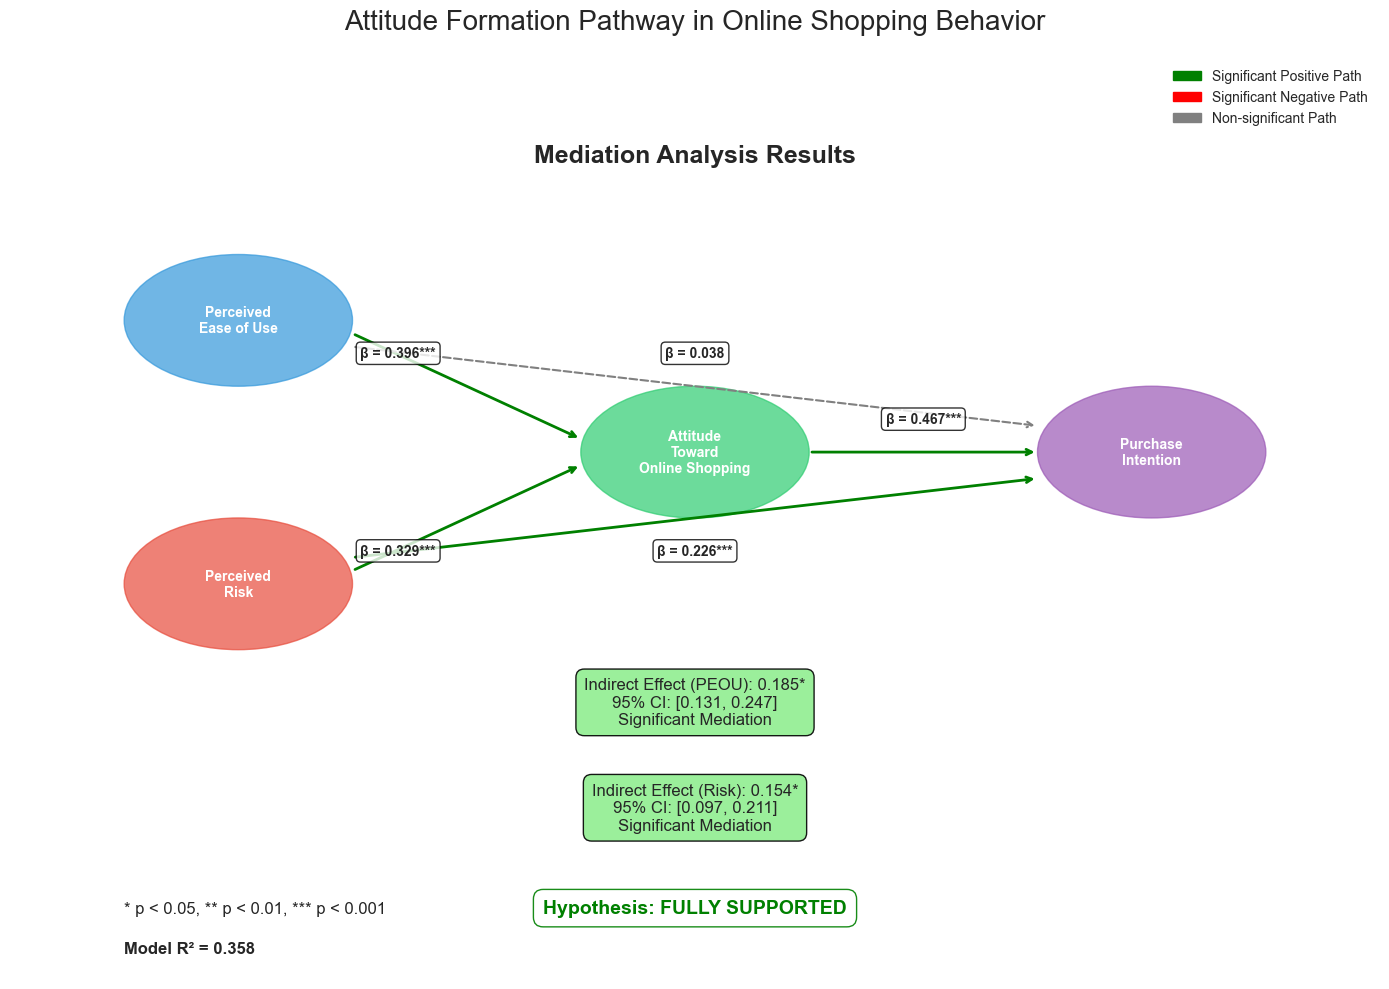

In [24]:
# Create a publication-quality visualization of the mediation model
plt.figure(figsize=(14, 10))
plt.style.use('seaborn-v0_8-whitegrid')

# Node positions
nodes = {
    'PEOU': (1, 3),
    'Risk': (1, 1),
    'Attitude': (3, 2),
    'Intention': (5, 2)
}

# Node colors based on variable type
colors = {
    'PEOU': '#3498db',     # Blue for independent variable
    'Risk': '#e74c3c',     # Red for independent variable
    'Attitude': '#2ecc71', # Green for mediator
    'Intention': '#9b59b6' # Purple for dependent variable
}

# Create clean labels for the diagram
labels = {
    'PEOU': 'Perceived\nEase of Use',
    'Risk': 'Perceived\nRisk',
    'Attitude': 'Attitude\nToward\nOnline Shopping',
    'Intention': 'Purchase\nIntention'
}

# Draw nodes
for name, (x, y) in nodes.items():
    circle = plt.Circle((x, y), 0.5, fill=True, color=colors[name], alpha=0.7, edgecolor='black', linewidth=1)
    plt.gca().add_patch(circle)
    plt.text(x, y, labels[name], ha='center', va='center', fontweight='bold', color='white')

# Arrow style based on significance
def get_arrow_style(p_value, effect):
    """Return arrow style based on significance and effect direction"""
    if p_value < 0.05:
        color = 'green' if effect > 0 else 'red'
        width = 2.0
        style = '-'
    else:
        color = 'gray'
        width = 1.5
        style = '--'
    return {'color': color, 'lw': width, 'ls': style}

# Draw arrows for each path
# PEOU -> Attitude (a1)
plt.annotate("", xy=(nodes['Attitude'][0]-0.5, nodes['Attitude'][1]+0.1), 
             xytext=(nodes['PEOU'][0]+0.5, nodes['PEOU'][1]-0.1),
             arrowprops=dict(arrowstyle="->", **get_arrow_style(model_a_peou.pvalues[1], a_peou)))

# Risk -> Attitude (a2)
plt.annotate("", xy=(nodes['Attitude'][0]-0.5, nodes['Attitude'][1]-0.1), 
             xytext=(nodes['Risk'][0]+0.5, nodes['Risk'][1]+0.1),
             arrowprops=dict(arrowstyle="->", **get_arrow_style(model_a_risk.pvalues[1], a_risk)))

# Attitude -> Intention (b)
plt.annotate("", xy=(nodes['Intention'][0]-0.5, nodes['Intention'][1]), 
             xytext=(nodes['Attitude'][0]+0.5, nodes['Attitude'][1]),
             arrowprops=dict(arrowstyle="->", **get_arrow_style(model_bc.pvalues['attitude_std'], b)))

# PEOU -> Intention (c')
plt.annotate("", xy=(nodes['Intention'][0]-0.5, nodes['Intention'][1]+0.2), 
             xytext=(nodes['PEOU'][0]+0.5, nodes['PEOU'][1]-0.2),
             arrowprops=dict(arrowstyle="->", **get_arrow_style(model_bc.pvalues['peou_std'], c_prime_peou)))

# Risk -> Intention (c')
plt.annotate("", xy=(nodes['Intention'][0]-0.5, nodes['Intention'][1]-0.2), 
             xytext=(nodes['Risk'][0]+0.5, nodes['Risk'][1]+0.2),
             arrowprops=dict(arrowstyle="->", **get_arrow_style(model_bc.pvalues['risk_std'], c_prime_risk)))

# Add coefficients with significance indicators
def format_coef(coef, p):
    """Format coefficient with asterisks for significance"""
    stars = ""
    if p < 0.05:
        stars = "*"
    if p < 0.01:
        stars = "**"
    if p < 0.001:
        stars = "***"
    return f"β = {coef:.3f}{stars}"

# Add coefficient labels
plt.text((nodes['PEOU'][0]+nodes['Attitude'][0])/2 - 0.3, 
         (nodes['PEOU'][1]+nodes['Attitude'][1])/2 + 0.25, 
         format_coef(a_peou, model_a_peou.pvalues[1]),
         ha='center', va='center', fontweight='bold', 
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

plt.text((nodes['Risk'][0]+nodes['Attitude'][0])/2 - 0.3, 
         (nodes['Risk'][1]+nodes['Attitude'][1])/2 - 0.25, 
         format_coef(a_risk, model_a_risk.pvalues[1]),
         ha='center', va='center', fontweight='bold', 
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

plt.text((nodes['Attitude'][0]+nodes['Intention'][0])/2, 
         (nodes['Attitude'][1]+nodes['Intention'][1])/2 + 0.25, 
         format_coef(b, model_bc.pvalues['attitude_std']),
         ha='center', va='center', fontweight='bold', 
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

plt.text((nodes['PEOU'][0]+nodes['Intention'][0])/2, 
         (nodes['PEOU'][1]+nodes['Intention'][1])/2 + 0.25, 
         format_coef(c_prime_peou, model_bc.pvalues['peou_std']),
         ha='center', va='center', fontweight='bold', 
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

plt.text((nodes['Risk'][0]+nodes['Intention'][0])/2, 
         (nodes['Risk'][1]+nodes['Intention'][1])/2 - 0.25, 
         format_coef(c_prime_risk, model_bc.pvalues['risk_std']),
         ha='center', va='center', fontweight='bold', 
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

# Add indirect effect information
indirect_box_peou = f"Indirect Effect (PEOU): {indirect_effect_peou:.3f}"
if bootstrap_results['peou_indirect_ci'][0] > 0 or bootstrap_results['peou_indirect_ci'][1] < 0:
    indirect_box_peou += "*"
indirect_box_peou += f"\n95% CI: [{bootstrap_results['peou_indirect_ci'][0]:.3f}, {bootstrap_results['peou_indirect_ci'][1]:.3f}]"
if bootstrap_results['peou_indirect_ci'][0] > 0 or bootstrap_results['peou_indirect_ci'][1] < 0:
    indirect_box_peou += "\nSignificant Mediation"
    box_color_peou = "lightgreen"
else:
    indirect_box_peou += "\nNo Significant Mediation"
    box_color_peou = "white"

indirect_box_risk = f"Indirect Effect (Risk): {indirect_effect_risk:.3f}"
if bootstrap_results['risk_indirect_ci'][0] > 0 or bootstrap_results['risk_indirect_ci'][1] < 0:
    indirect_box_risk += "*"
indirect_box_risk += f"\n95% CI: [{bootstrap_results['risk_indirect_ci'][0]:.3f}, {bootstrap_results['risk_indirect_ci'][1]:.3f}]"
if bootstrap_results['risk_indirect_ci'][0] > 0 or bootstrap_results['risk_indirect_ci'][1] < 0:
    indirect_box_risk += "\nSignificant Mediation"
    box_color_risk = "lightgreen"
else:
    indirect_box_risk += "\nNo Significant Mediation"
    box_color_risk = "white"

plt.text(3, 4.2, "Mediation Analysis Results", fontsize=18, fontweight='bold', ha='center')
plt.text(3, 0.1, indirect_box_peou, ha='center', va='center', fontsize=12,
         bbox=dict(boxstyle="round,pad=0.5", fc=box_color_peou, ec="black", alpha=0.9))
plt.text(3, -0.7, indirect_box_risk, ha='center', va='center', fontsize=12,
         bbox=dict(boxstyle="round,pad=0.5", fc=box_color_risk, ec="black", alpha=0.9))

# Add legend for significance
plt.text(0.5, -1.5, "* p < 0.05, ** p < 0.01, *** p < 0.001", fontsize=12, ha='left')
plt.text(0.5, -1.8, f"Model R² = {r2_intention_full:.3f}", fontsize=12, ha='left', fontweight='bold')

# Add hypothesis conclusion
if hypothesis_status == "FULLY SUPPORTED":
    conclusion_color = "green"
elif hypothesis_status == "PARTIALLY SUPPORTED":
    conclusion_color = "orange"
else:
    conclusion_color = "red"

plt.text(3, -1.5, f"Hypothesis: {hypothesis_status}", fontsize=14, fontweight='bold', ha='center', color=conclusion_color,
         bbox=dict(boxstyle="round,pad=0.5", fc="white", ec=conclusion_color, alpha=0.9))

# Add legend for arrows
solid_line = mpatches.Patch(color='green', label='Significant Positive Path')
dashed_line = mpatches.Patch(color='gray', label='Non-significant Path')
negative_line = mpatches.Patch(color='red', label='Significant Negative Path')
plt.legend(handles=[solid_line, negative_line, dashed_line], loc='upper right', framealpha=0.9)

# Overall formatting
plt.title('Attitude Formation Pathway in Online Shopping Behavior', fontsize=20, pad=20)
plt.xlim(0, 6)
plt.ylim(-2, 5)
plt.axis('off')
plt.tight_layout()
plt.savefig('../../outputs/hypothesis_19/attitude_formation_pathway.png', dpi=300, bbox_inches='tight')
plt.show()



## 10. Practical Recommendations and Business Implications



In [25]:
print("\n=== Practical Recommendations and Business Implications ===\n")

# Generate applicable business recommendations based on findings
print("Strategic Recommendations for E-Commerce Platforms:")

if peou_mediation_significant:
    print("\n1. Leverage the Ease of Use → Attitude → Purchase Intention Pathway")
    print("   • Streamline navigation and checkout processes to improve ease of use")
    print("   • Highlight user-friendly features in marketing communications")
    print("   • Implement A/B testing focused on usability improvements")
    print("   • Develop onboarding tutorials for new users to improve perceived ease of use")
    print("   • Create clear, visually intuitive interfaces to foster positive attitudes")

if risk_mediation_significant:
    print("\n2. Address the Risk → Attitude → Purchase Intention Pathway")
    if a_risk < 0:  # Negative relationship between risk and attitude
        print("   • Implement visible security badges and certifications")
        print("   • Clearly communicate privacy policies and customer protections")
        print("   • Offer secure payment options and highlight their benefits")
        print("   • Provide transparent return policies to reduce perceived risk")
        print("   • Use trust signals throughout the customer journey")
    else:  # Positive relationship (unusual but possible in the data)
        print("   • Investigate why higher risk perception links to positive attitudes")
        print("   • Consider if perceived risk creates excitement or exclusivity perceptions")
        print("   • Explore if limited-time offers leverage mild anxiety productively")

print("\n3. Attitude Improvement Strategies")
print("   • Develop comprehensive brand messaging focused on positive shopping experiences")
print("   • Use social proof and testimonials to shape positive attitudes")
print("   • Create content highlighting the benefits of online shopping during crises")
print("   • Design loyalty programs that reinforce positive attitudes")
print("   • Provide incentives that encourage positive word-of-mouth")

print("\n4. Measurement and Optimization")
print("   • Regularly measure customer attitudes using brief satisfaction surveys")
print("   • Track ease of use metrics through usability testing and analytics")
print("   • Monitor risk perception through feedback and security concern reporting")
print("   • Test messaging that targets attitude formation rather than direct purchase appeals")
print("   • Develop KPIs that include attitudinal metrics alongside behavioral ones")

print("\n5. Implementation Priority Framework")
if peou_mediation_significant and not risk_mediation_significant:
    print("   • HIGH PRIORITY: Ease of use improvements")
    print("   • MEDIUM PRIORITY: Attitude formation campaigns")
    print("   • LOW PRIORITY: Risk perception management")
elif risk_mediation_significant and not peou_mediation_significant:
    print("   • HIGH PRIORITY: Risk perception management")
    print("   • MEDIUM PRIORITY: Attitude formation campaigns")
    print("   • LOW PRIORITY: Ease of use improvements")
elif peou_mediation_significant and risk_mediation_significant:
    if abs(indirect_effect_peou) > abs(indirect_effect_risk):
        print("   • HIGH PRIORITY: Ease of use improvements")
        print("   • HIGH PRIORITY: Attitude formation campaigns")
        print("   • MEDIUM PRIORITY: Risk perception management")
    else:
        print("   • HIGH PRIORITY: Risk perception management")
        print("   • HIGH PRIORITY: Attitude formation campaigns")
        print("   • MEDIUM PRIORITY: Ease of use improvements")
else:
    print("   • MEDIUM PRIORITY: Direct focus on purchase intention drivers")
    print("   • MEDIUM PRIORITY: Ease of use improvements")
    print("   • MEDIUM PRIORITY: Risk perception management")
    print("   • LOW PRIORITY: Attitude formation campaigns")

print("\n6. Market Segmentation Approach")
print("   • Identify customer segments most influenced by the attitude-mediated pathway")
print("   • Target attitude-focused messaging to segments with strong path coefficients")
print("   • Develop different communications for new vs. returning customers")
print("   • Consider demographic and behavioral differences in attitude formation")
print("   • Customize ease of use and security features based on segment sensitivities")

print("\n7. Competitive Advantage Creation")
print("   • Position against competitors based on strongest attitudinal drivers")
print("   • Create brand differentiation through ease of use if PEOU mediation is significant")
print("   • Emphasize security and authenticity if risk mediation is significant")
print("   • Develop marketing communications that emphasize the specific attitude pathway")
print("   • Invest in customer experience features that reinforce the mediation pathway")


=== Practical Recommendations and Business Implications ===

Strategic Recommendations for E-Commerce Platforms:

1. Leverage the Ease of Use → Attitude → Purchase Intention Pathway
   • Streamline navigation and checkout processes to improve ease of use
   • Highlight user-friendly features in marketing communications
   • Implement A/B testing focused on usability improvements
   • Develop onboarding tutorials for new users to improve perceived ease of use
   • Create clear, visually intuitive interfaces to foster positive attitudes

2. Address the Risk → Attitude → Purchase Intention Pathway
   • Investigate why higher risk perception links to positive attitudes
   • Consider if perceived risk creates excitement or exclusivity perceptions
   • Explore if limited-time offers leverage mild anxiety productively

3. Attitude Improvement Strategies
   • Develop comprehensive brand messaging focused on positive shopping experiences
   • Use social proof and testimonials to shape positive